<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/example_kaggle/les_7/Module7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation systems

In [1]:
!pip install "numpy<2.0.0" --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# Налаштування середовища
!pip install scikit-surprise

In [3]:
import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic, NMF, SVDpp, BaselineOnly, KNNWithMeans, KNNWithZScore, KNNBaseline, SlopeOne, CoClustering
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from surprise.accuracy import rmse

In [4]:
# Завантаження датасету ml-100k
data = Dataset.load_builtin("ml-100k")

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [5]:
train_set, test_set = train_test_split(data, test_size=0.25, random_state=42)

### Utils

In [6]:
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def invert_dictionary(dictionary):
    return {v: k for k, v in dictionary.items()}

def surprise_train_set_to_df(train_set, col_user="uid", col_item="iid", col_rating="rating"):
    df = pd.DataFrame(train_set.all_ratings(), columns=[col_user, col_item, col_rating])
    map_user = train_set._inner2raw_id_users if train_set._inner2raw_id_users is not None else invert_dictionary(train_set._raw2inner_id_users)
    map_item = train_set._inner2raw_id_items if train_set._inner2raw_id_items is not None else invert_dictionary(train_set._raw2inner_id_items)
    df[col_user] = df[col_user].map(map_user)
    df[col_item] = df[col_item].map(map_item)
    return df

# Функція для виведення топ-N рекомендацій
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

## EDA

In [7]:
# Load the ratings data
train_set_df = surprise_train_set_to_df(train_set)

In [8]:
train_set_df

,uid,iid,rating
0,877,381,4.0
1,877,451,4.0
2,877,557,4.0
3,877,692,4.0
4,877,56,5.0
...,...,...,...
74995,34,332,5.0
74996,34,990,5.0
74997,34,294,1.0
74998,34,312,4.0


In [9]:
# Head
train_set_df.head()

,uid,iid,rating
0,877,381,4.0
1,877,451,4.0
2,877,557,4.0
3,877,692,4.0
4,877,56,5.0


In [10]:
len(train_set_df)

75000

In [11]:
# Describe
train_set_df.describe()

,rating
count,75000.00000
mean,3.53064
std,1.12433
min,1.00000
25%,3.00000
50%,4.00000
75%,4.00000
max,5.00000


In [12]:
# Info
train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   uid     75000 non-null  object 
 1   iid     75000 non-null  object 
 2   rating  75000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


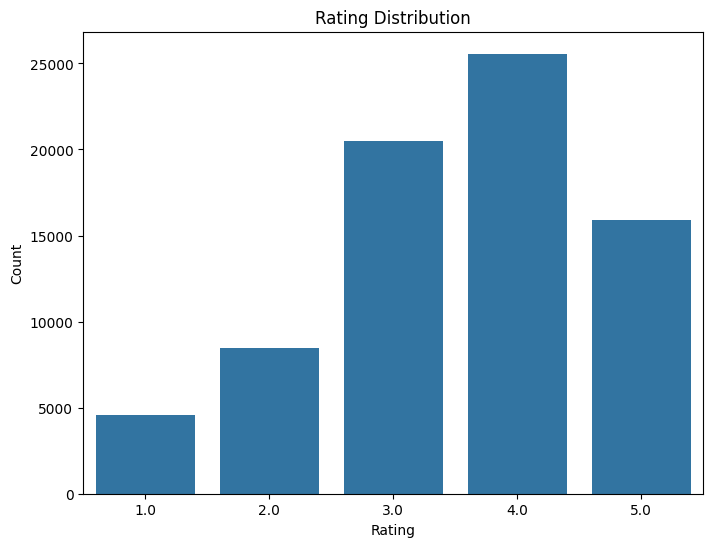

In [13]:
#  Rating Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="rating", data=train_set_df)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

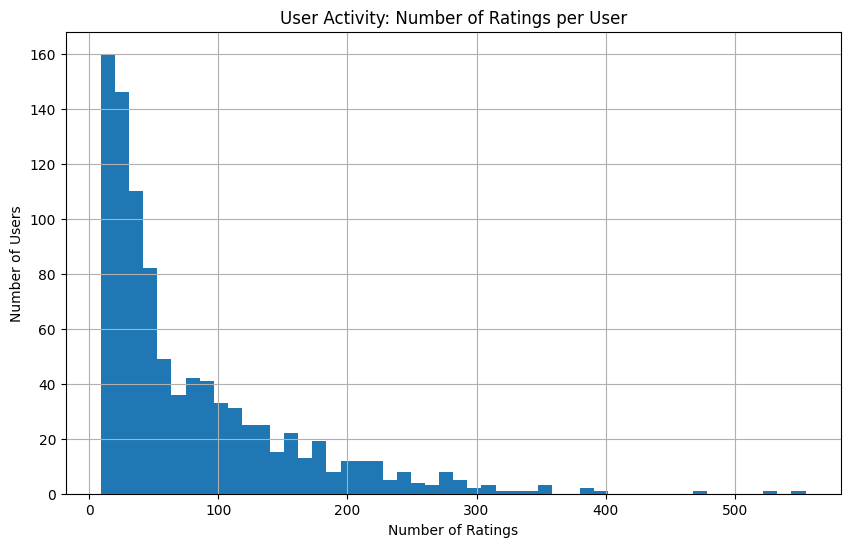

In [14]:
# User Activity: Number of Ratings per User
user_ratings_count = train_set_df.groupby("uid")["rating"].count().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
user_ratings_count.hist(bins=50)
plt.title("User Activity: Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

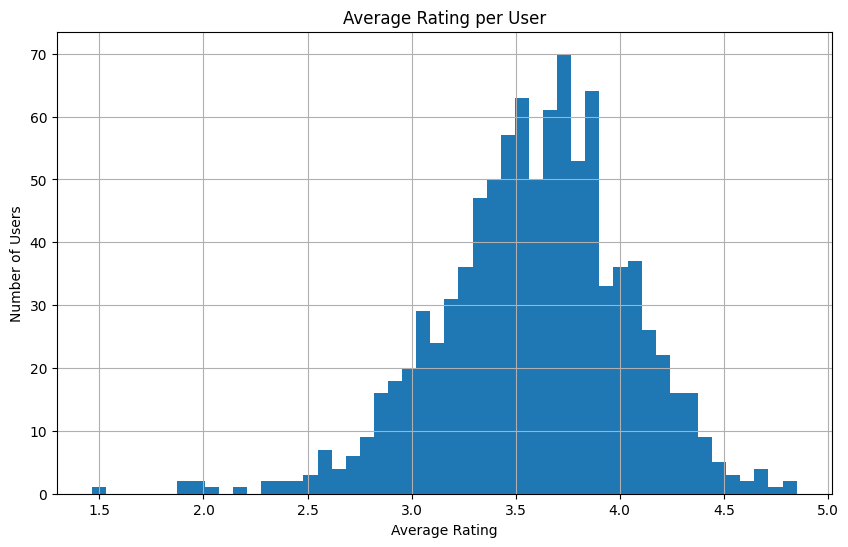

In [15]:
# Average Rating per User
avg_user_rating = train_set_df.groupby("uid")["rating"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_user_rating.hist(bins=50)
plt.title("Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()

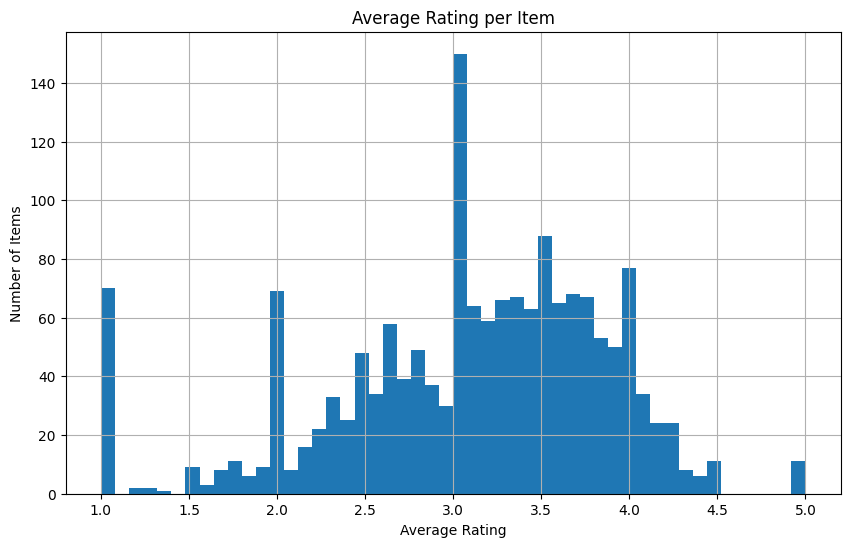

In [16]:
# Average Rating per Item
avg_item_rating = train_set_df.groupby("iid")["rating"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_item_rating.hist(bins=50)
plt.title("Average Rating per Item")
plt.xlabel("Average Rating")
plt.ylabel("Number of Items")
plt.show()

[Dense or sparse a dataset](https://www.geeksforgeeks.org/how-to-calculate-how-dense-or-sparse-a-dataset-is/)

In [17]:
# Sparsity of the Rating Matrix (important for collaborative filtering)
num_users = train_set_df["uid"].nunique()
num_items = train_set_df["iid"].nunique()
num_ratings = len(train_set_df)

In [18]:
num_users, num_items

(943, 1644)

In [19]:
num_ratings, num_users * num_items

(75000, 1550292)

In [20]:
sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9516


Text(0, 0.5, 'Average Rating')

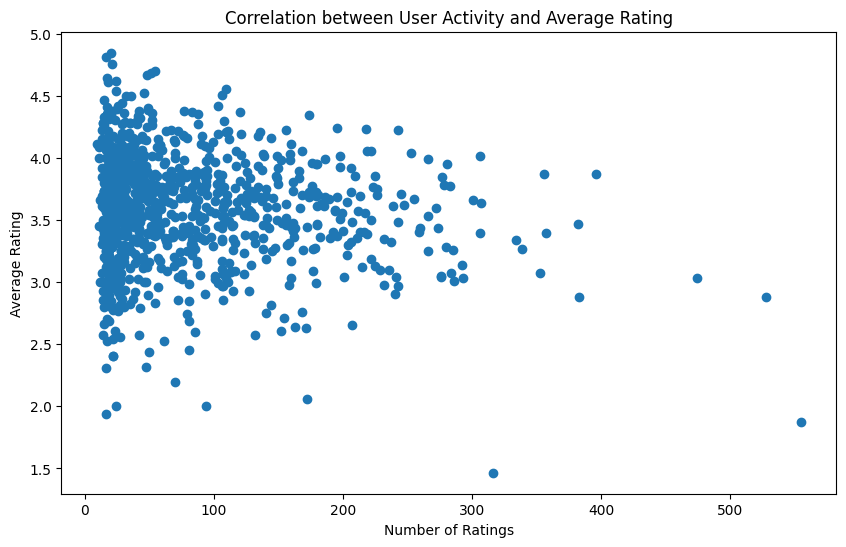

In [21]:
# Кореляція між активністю користувачів та середнім рейтингом
user_stats = train_set_df.groupby("uid").agg({"rating": ["count", "mean"]})
plt.figure(figsize=(10, 6))
plt.scatter(user_stats["rating"]["count"], user_stats["rating"]["mean"])
plt.title("Correlation between User Activity and Average Rating")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")

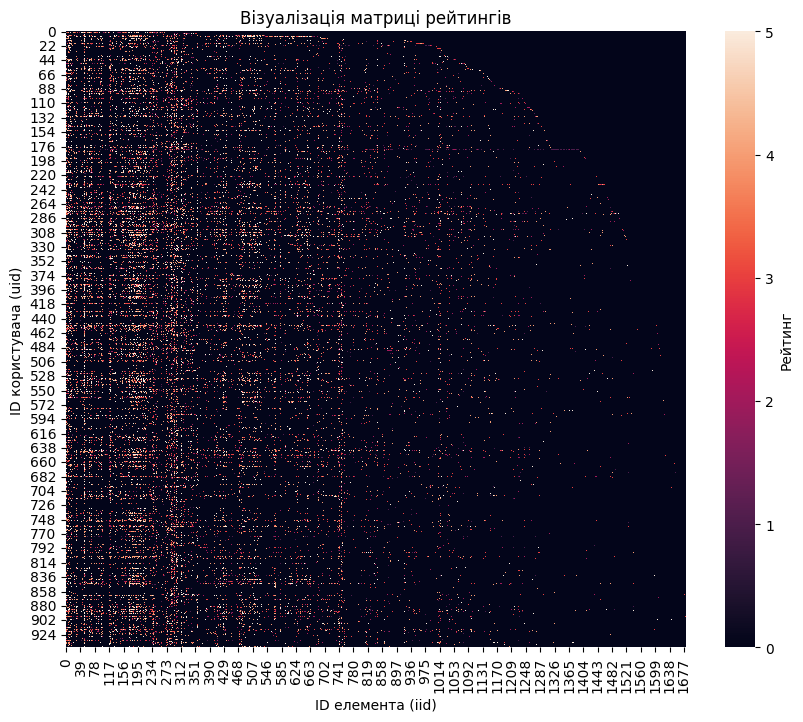

In [22]:
from scipy.sparse import csr_matrix

# Візуалізація матриці рейтингів (heatmap)
rating_matrix = csr_matrix((train_set_df['rating'], (train_set_df['uid'].to_numpy(dtype=int), train_set_df['iid'].to_numpy(dtype=int))))
plt.figure(figsize=(10, 8))
sns.heatmap(rating_matrix.todense(), cbar_kws={'label': 'Рейтинг'})
plt.title('Візуалізація матриці рейтингів')
plt.xlabel('ID елемента (iid)')
plt.ylabel('ID користувача (uid)')
plt.show()

In [23]:
# Item Popularity: Number of Ratings per Item


## SVD (Сингулярний розклад) у контексті колаборативної фільтрації

Незважаючи на назву, SVD в Surprise (та багатьох інших бібліотеках рекомендаційних систем) не є класичним сингулярним розкладом матриці. Це адаптація ідеї факторизації матриці, оптимізована для розріджених даних та проблем, з якими стикаються рекомендаційні системи.

Алгоритм SVD в Surprise намагається знайти дві матриці - матрицю прихованих факторів користувачів (P) та матрицю прихованих факторів елементів (Q) - таким чином, щоб їх добуток наближував оригінальну матрицю рейтингів. Крім того, використовуються зміщення для врахування особливостей кожного користувача та елемента.

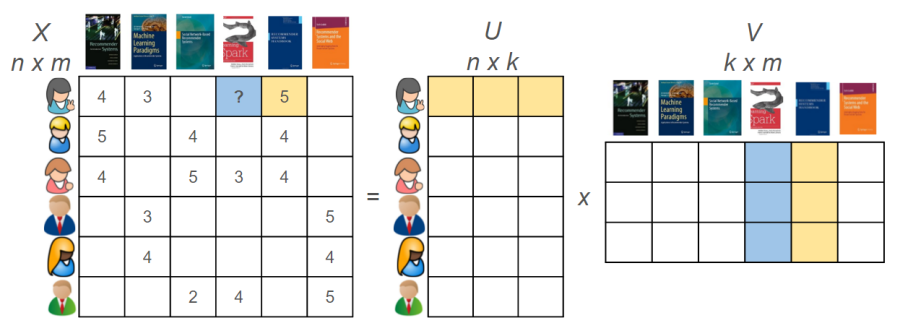

Прогнозований рейтинг розраховується за формулою:

$\hat{r}_{ui} = \mu + b_u + b_i + p_u^T q_i$

Де:

- $\hat{r}_{ui}$ - прогнозований рейтинг користувача u для елемента i
- $\mu$ - середній рейтинг у наборі даних
- $b_u$ - зміщення користувача u (наскільки в середньому рейтинги користувача відрізняються від середнього)
- $b_i$ - зміщення елемента i (наскільки в середньому рейтинги елемента відрізняються від середнього)
- $p_u$ - вектор прихованих факторів користувача u (відображає його вподобання)
- $q_i$ - вектор прихованих факторів елемента i (відображає його характеристики)

**Важливо**: Матриця сингулярних значень (Σ), яка є частиною класичного SVD, тут не використовується безпосередньо в процесі прогнозування. Інформація про важливість латентних факторів неявно враховується при навчанні матриць P і Q.

In [24]:
# Ініціалізація та навчання моделі SVD
svd = SVD(n_factors=100, n_epochs=1000, lr_all=0.005, reg_all=0.02)
svd.fit(train_set)

In [25]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = svd.predict(uid, iid, r_ui=4, verbose=True)

user: 196        item: 302        r_ui = 4.00   est = 4.02   {'was_impossible': False}


In [26]:
# Run 5-fold cross-validation and print results
cv_result = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9623  0.9653  0.9669  0.9618  0.9551  0.9623  0.0041  
MAE (testset)     0.7567  0.7585  0.7605  0.7567  0.7489  0.7563  0.0039  
Fit time          75.99   75.70   78.09   77.40   78.93   77.22   1.23    
Test time         0.43    0.12    0.14    0.64    0.11    0.29    0.21    


In [27]:
import numpy as np

In [28]:
from surprise.model_selection.search import GridSearchCV

param_grid = {
    "n_factors": [8, 10, 12],
    "n_epochs": [15, 20, 25],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

In [29]:
gs.best_score, gs.best_params

({'rmse': 0.9381867033888228, 'mae': 0.7395552676018506},
 {'rmse': {'n_factors': 10, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.02},
  'mae': {'n_factors': 10, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.02}})

In [30]:
# Виведення топ-10 рекомендацій для кожного користувача


**Переваги:**
- Добре працює на відносно щільних наборах даних.
- Досить швидкий в навчанні та прогнозуванні.
- Зрозуміла інтерпретація латентних факторів.

**Недоліки:**
- Може страждати від проблеми "холодного старту" (проблематично робити прогнози для нових користувачів або елементів).
- Не враховує неявні зворотні зв'язки.

## Original SVD

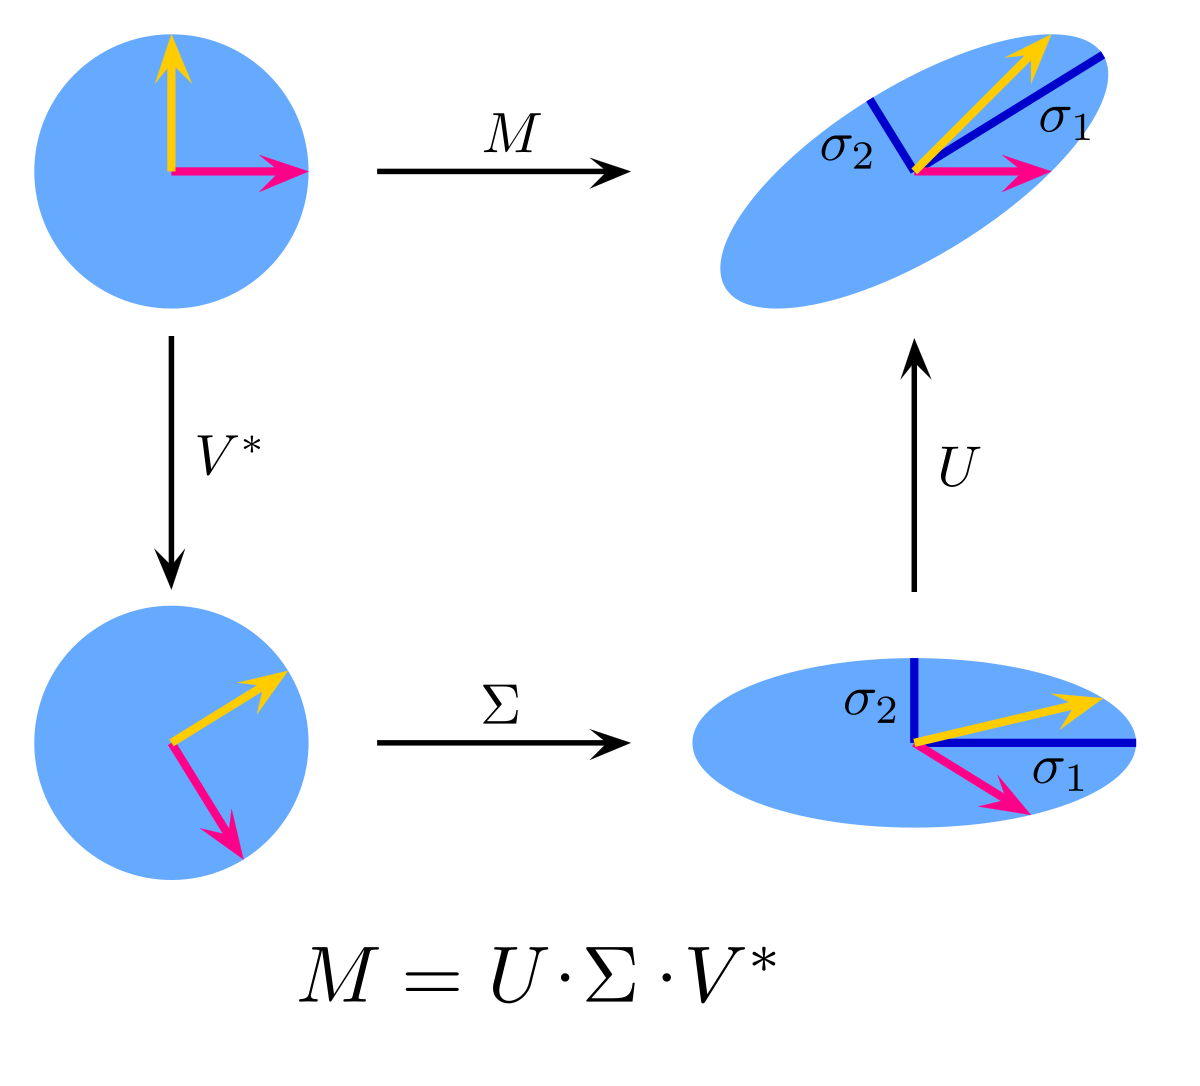

**Математична операція з лінійної алгебри**: розкладає будь-яку прямокутну матрицю A (не обов'язково з рейтингами) на добуток трьох матриць:

$A = U \Sigma V^T$

Де:
- U: Ортогональна матриця лівих сингулярних векторів
- Σ: Діагональна матриця сингулярних значень (вказують на важливість відповідного латентного фактора)
- V<sup>T</sup>: Транспонована ортогональна матриця правих сингулярних векторів.
Застосування: Зменшення розмірності, стиснення даних, виділення ознак, рекомендаційні системи.

**Зв'язок з колаборативною фільтрацією**

Ідея запозичена, але адаптована: Алгоритми SVD та SVD++ в рекомендаційних системах запозичують ідею факторизації матриці від оригінального SVD, але:
Вони адаптовані для роботи з розрідженими даними (багато пропущених значень).
Використовують оптимізаційні методи (наприклад, градієнтний спуск) для навчання матриць факторів, а не прямий розклад, як в оригінальному SVD.
Часто не використовують матрицю сингулярних значень (Σ) безпосередньо в процесі прогнозування.

## SVD++

**SVD++** - це розширення алгоритму SVD, яке враховує неявні зворотні зв'язки від користувачів, такі як перегляди, додавання в кошик або список бажань. Ця інформація допомагає краще зрозуміти вподобання користувачів та підвищити точність рекомендацій.

SVD++ додає до формули SVD новий вектор yj, який представляє неявні фактори елемента j. Цей вектор враховує вплив усіх елементів, з якими взаємодіяв користувач, на його передбачуваний рейтинг для поточного елемента.

$\hat{r}_{ui} = \mu + b_u + b_i + q_i^T (p_u + |I_u|^{-\frac{1}{2}} \sum_{j \in I_u} y_j)$

Де:

- $\hat{r}_{ui}$, $\mu$, $b_u$, $b_i$, $p_u$ та $q_i$ мають таке ж значення, як і в SVD.
- $I_u$ - множина елементів, з якими взаємодіяв користувач u (навіть якщо він не поставив явний рейтинг)
- $y_j$ - вектор неявних факторів елемента j (відображає його вплив на інші елементи)

Якщо порівняти формулу SVD++ з SVD, то можна помітити, що єдина відмінність - це додавання фактора $I_u$. Його можна інтерпретувати як врахування впливу "неявної" інформації, на відміну від p(u), який включає лише вплив "явної".

Справа в тому, що сам факт оцінювання користувачем елемента вже є свідченням його уподобань. Іншими словами, ймовірність того, що користувачеві "подобається" елемент, який він оцінив, вища, ніж для випадкового неоціненого елемента.

Ще одна цікава особливість цього терміну полягає в тому, що він не включає фактор користувача. Це позитивно впливає на прогнозування для нових користувачів, для яких у нас може бути недостатньо даних, щоб сформувати точні вектори факторів.

In [31]:
# Ініціалізація та навчання моделі
svdpp = SVDpp(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.02)
svdpp.fit(train_set)

In [32]:
predictions = svdpp.test(test_set)
rmse_score = accuracy.rmse(predictions)

RMSE: 0.9226


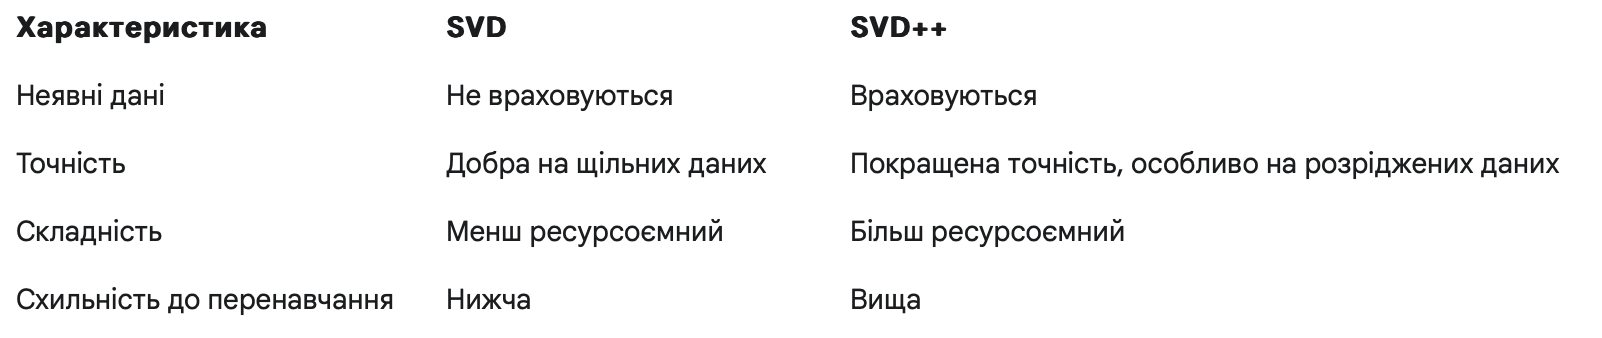

**Переваги:**
- Вища точність порівняно з SVD, особливо на розріджених даних.
- Ефективно враховує неявну інформацію.

**Недоліки:**
- Більш ресурсоємний алгоритм, ніж SVD.
- Може бути схильним до перенавчання.

More about the topic:
- [Model Based Collaborative Filtering ](https://medium.com/@corymaklin/model-based-collaborative-filtering-svd-19859c764cee)
- [Whats the difference between SVD and SVD++](https://www.quora.com/Whats-the-difference-between-SVD-and-SVD++)
- [SVD Visualized, Singular Value Decomposition explained](https://www.youtube.com/watch?v=vSczTbgc8Rc)

## RandomPredictor

**RandomPredictor** - це найпростіший алгоритм прогнозування в Surprise, який повністю ігнорує вхідні дані та генерує випадкові рейтинги на основі розподілу рейтингу навчального набору. Цей алгоритм не призначений для створення реальних рекомендацій, а слугує базовою лінією для порівняння з іншими, складнішими алгоритмами.

In [33]:
from surprise import NormalPredictor
from surprise.model_selection import cross_validate

# Ініціалізація та оцінка RandomPredictor
random_pred = NormalPredictor()
random_pred.fit(train_set)

predictions = random_pred.test(test_set)
rmse_score = accuracy.rmse(predictions)

RMSE: 1.5256


## BaselineOnly

Цей алгоритм прогнозує рейтинг, використовуючи лише базові значення для користувачів та елементів. Базові оцінки обчислюються як середній рейтинг для кожного користувача або елемента, скоригований на загальний середній рейтинг.

$\hat{r}_{ui} = \mu + b_u + b_i$

Де:

- $\hat{r}_{ui}$ - прогнозований рейтинг користувача u для елемента i
- $\mu$ - середній рейтинг у наборі даних
- $b_u$ - зміщення користувача u
- $b_i$ - зміщення елемента i

In [34]:
baseline_only = BaselineOnly()
baseline_only.fit(train_set)

predictions = baseline_only.test(test_set)
rmse_score = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9474


## Методи на основі K-найближчих сусідів (k-NN)

Алгоритми k-NN базуються на ідеї, що користувачі з подібними вподобаннями в минулому будуть мати схожі вподобання в майбутньому. Для прогнозування рейтингу k-NN шукає k найближчих сусідів користувача (або елемента) та усереднює їх рейтинги.

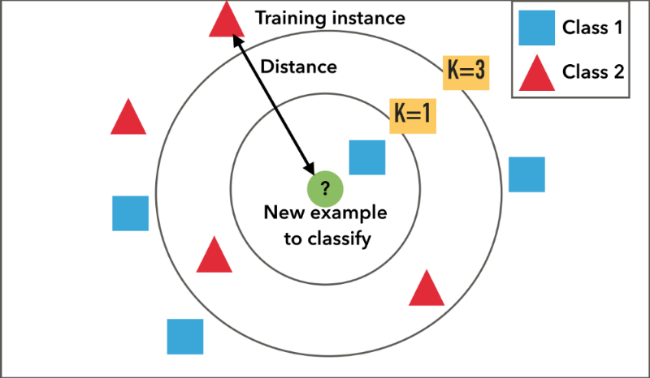

### KNNBasic

Цей алгоритм прогнозує рейтинг користувача на елемент, усереднюючи рейтинги k-найближчих сусідів, які оцінили цей елемент.

$\hat{r}_{ui} = \frac{\sum_{v \in N_i^k(u)} sim(u,v) \times r_{vi}}{\sum_{v \in N_i^k(u)} |sim(u,v)|}$

де:
- $\hat{r}_{ui}$ - прогнозований рейтинг користувача u для елемента i
- $N_i^k(u)$ - множина k найближчих сусідів користувача u, які оцінили елемент i
- $sim(u,v)$ - міра подібності між користувачами u та v (наприклад, косинусна подібність)
- $r_{vi}$ - рейтинг користувача v для елемента i

In [35]:
from surprise import KNNBasic
from surprise.model_selection import train_test_split

# Ініціалізація та навчання KNNBasic
knn = KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True})
knn.fit(train_set)

# Прогнозування рейтингу
uid = str(196)  # ID користувача
iid = str(302)  # ID елемента
prediction = knn.predict(uid, iid)
print(prediction.est)

Computing the cosine similarity matrix...
Done computing similarity matrix.
4.125


In [36]:
prediction = knn.test(test_set)
accuracy.rmse(prediction)

RMSE: 1.0223


1.022276156768975

Інші варіації:
- **KNNWithMeans**: Враховує середній рейтинг кожного користувача при прогнозуванні.
- **KNNWithZScore**: Використовує z-оцінку рейтингу користувача для нормалізації.
- **KNNBaseline**: Враховує базові значення користувачів та елементів, як в алгоритмі BaselineOnly.

In [37]:
# KNNWithMeans
knn_means = KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': True})
knn_means.fit(train_set)
predictions = knn_means.test(test_set)
accuracy.rmse(predictions)

# KNNWithZScore
knn_zscore = KNNWithZScore(k=40, sim_options={'name': 'cosine', 'user_based': True})
knn_zscore.fit(train_set)
predictions = knn_zscore.test(test_set)
accuracy.rmse(predictions)

# KNNBaseline
knn_baseline = KNNBaseline(k=40, sim_options={'name': 'cosine', 'user_based': True})
knn_baseline.fit(train_set)
predictions = knn_baseline.test(test_set)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9600
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9599
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9376


0.9376039316021423

## NMF (Не негативне матричне розкладання)

**NMF** - це техніка матричної факторизації, яка розкладає оригінальну матрицю рейтингів на дві матриці меншого рангу з невід'ємними значеннями. Це обмеження допомагає інтерпретувати отримані фактори як "складові частини" елементів та вподобань користувачів.

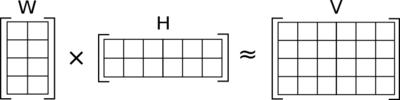

$R \approx P \times Q$

Де:
- $R$ - оригінальна матриця рейтингів
- $P$ - матриця прихованих факторів користувачів (невід'ємні значення)
- $Q$ - матриця прихованих факторів елементів (невід'ємні значення)

In [38]:
from surprise import NMF
from surprise.model_selection import cross_validate

# Ініціалізація та навчання NMF
nmf = NMF(n_factors=15, n_epochs=50)
nmf.fit(train_set)
predictions = nmf.test(test_set)
accuracy.rmse(predictions)

RMSE: 0.9719


0.9718923711638331

Обмеження невід'ємності факторів користувачів та елементів в NMF має кілька важливих наслідків:

- **Інтерпретація**: Невід'ємні значення дозволяють інтерпретувати латентні фактори як "складові частини" або "ознаки". Наприклад, якщо ми маємо справу з фільмами, то фактор може представляти жанр (комедія, драма, екшн), актора або іншу характеристику фільму. Коефіцієнт в матриці факторів елементів (Q) показує, наскільки сильно ця ознака присутня в конкретному фільмі. Аналогічно, коефіцієнт в матриці факторів користувачів (P) відображає, наскільки сильно користувач цінує цю ознаку.
- **Адитивність**: Оскільки всі значення невід'ємні, прогнозований рейтинг розраховується шляхом додавання вкладів різних факторів. Це відповідає інтуїтивному уявленню про те, що рейтинг формується шляхом комбінування різних аспектів фільму (або іншого елемента), які подобаються або не подобаються користувачеві.
- **Розрідженість**: NMF часто призводить до розріджених матриць факторів, де багато значень дорівнюють нулю. Це означає, що кожен користувач та елемент описується лише невеликою кількістю факторів, що спрощує інтерпретацію та може сприяти узагальненню моделі.

# [Guide to Build a Recommendation Engine from Scratch](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/)